# DETR Object Detection: Fine-tuning on COCO Subset

## Overview

This notebook demonstrates **transformer-based object detection** using **DETR (DEtection TRansformer)** from Facebook AI Research. We'll fine-tune a pre-trained DETR model on a subset of the COCO dataset containing 10 common object classes.

### DETR Architecture Quick Reference

**Components**:
- **Backbone**: ResNet-50 CNN (frozen during fine-tuning)
- **Transformer Encoder**: Processes image features
- **Transformer Decoder**: 100 learnable object queries
- **Prediction Heads**: Classification + Bounding Box for each query

**Loss Function** (weighted combination):
1. **Classification Loss** (Cross-Entropy): Predicts object class
2. **Box L1 Loss**: L1 distance between predicted and ground truth boxes
3. **GIoU Loss**: Generalized Intersection over Union

**Training Strategy**:
- **Hungarian Matching**: Finds optimal bipartite matching between predictions and targets
- **Set-Based Loss**: Unlike traditional detectors, computes loss on the entire set of predictions

---


## 1. Configuration & Setup

Centralized configuration for reproducibility and easy experimentation.


In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T
from torchvision.ops import box_iou
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
import fiftyone as fo
import fiftyone.zoo as foz
from transformers import DetrImageProcessor, DetrForObjectDetection
from datetime import datetime

/home/chikibriki/hw2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
if torch.cuda.is_available():
    # Get total memory for device 0 (first GPU)
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3) # Convert to GB
    
    # Get allocated and reserved memory for device 0
    allocated_memory = torch.cuda.memory_allocated(0) / (1024**3)
    reserved_memory = torch.cuda.memory_reserved(0) / (1024**3)

    print(f"Total GPU Memory (device 0): {total_memory:.2f} GB")
    print(f"Allocated GPU Memory (device 0): {allocated_memory:.2f} GB")
    print(f"Reserved GPU Memory (device 0): {reserved_memory:.2f} GB")
else:
    print("CUDA is not available. PyTorch GPU functions cannot be used.")

Total GPU Memory (device 0): 79.25 GB
Allocated GPU Memory (device 0): 0.00 GB
Reserved GPU Memory (device 0): 0.00 GB


### Hyperparameter Configuration

All key hyperparameters are defined here for easy modification and experimentation.


In [4]:
DESIRED_CLASSES = ["person", "car", "dog", "cat", "bicycle", "motorcycle", "airplane", "bus", "train", "truck"]
DATA_DIR = Path("./coco_subset_data")
DATA_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR = Path("./checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)
TB_LOG_DIR = Path("./runs") / datetime.now().strftime("%Y%m%d")
TB_LOG_DIR.mkdir(parents=True, exist_ok=True)
print(f"Data directory: {DATA_DIR}")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print(f"TensorBoard log directory: {TB_LOG_DIR}")

Data directory: coco_subset_data
Checkpoint directory: checkpoints
TensorBoard log directory: runs/20251202


---
## 2. Dataset Preparation

We use **FiftyOne** to download and manage COCO dataset subsets. The dataset is cached locally for faster subsequent runs.

**Dataset Statistics**:
- **Classes**: 10 common objects (person, car, dog, cat, bicycle, motorcycle, airplane, bus, train, truck)
- **Train set**: 2000 images
- **Validation set**: 500 images
- **Format**: COCO detection format (JSON annotations + images)


In [5]:
EXPORT_DIR = DATA_DIR
train_export_path = EXPORT_DIR / "train"
val_export_path = EXPORT_DIR / "validation"
train_dataset_name = "coco_subset_train"
val_dataset_name = "coco_subset_val"

def load_or_create_split(split_name, export_path, dataset_name, max_samples):
        
        labels_file = export_path / "labels.json"
        
        if labels_file.exists():
            print(f"Found cached {split_name} data at {export_path}")
            print(f"Loading {split_name} from disk...")
            
            if dataset_name in fo.list_datasets():
                fo.delete_dataset(dataset_name)
            
            dataset = fo.Dataset.from_dir(
                dataset_dir=str(export_path),
                dataset_type=fo.types.COCODetectionDataset,
                name=dataset_name,
                label_field="detections"
            )
            
            print(f"Loaded {len(dataset)} {split_name} samples from cache")
            
        else:
            print(f"No cached data found. Downloading {split_name} split...")
            
            dataset = foz.load_zoo_dataset(
                "coco-2017",
                split=split_name,
                label_types=["detections"],
                classes=DESIRED_CLASSES,
                max_samples=max_samples,
                only_matching=True,
                dataset_name=dataset_name
            )
            
            print(f"Downloaded {len(dataset)} {split_name} samples")
            
            print(f"Exporting {split_name} to {export_path}...")
            export_path.mkdir(parents=True, exist_ok=True)
            
            dataset.export(
                export_dir=str(export_path),
                dataset_type=fo.types.COCODetectionDetector,
                label_field="detections"
            )
            
            print(f"Exported {split_name} data to disk")
        
        return dataset

In [6]:
print("Loading Train Split")
dataset_train = load_or_create_split(
    split_name="train",
    export_path=train_export_path,
    dataset_name=train_dataset_name,
    max_samples=2000
)
print("Loading Validation Split")
dataset_val = load_or_create_split(
    split_name="validation",
    export_path=val_export_path,
    dataset_name=val_dataset_name,
    max_samples=500
)

Loading Train Split
Found cached train data at coco_subset_data/train
Loading train from disk...
 100% |███████████████| 2000/2000 [6.2s elapsed, 0s remaining, 339.4 samples/s]      
Loaded 2000 train samples from cache
Loading Validation Split
Found cached validation data at coco_subset_data/validation
Loading validation from disk...
 100% |█████████████████| 500/500 [1.4s elapsed, 0s remaining, 358.6 samples/s]         
Loaded 500 validation samples from cache


In [7]:
print(f"Train samples: {len(dataset_train)}")
print(f"Validation samples: {len(dataset_val)}")

Train samples: 2000
Validation samples: 500


In [8]:
train_dataset, val_dataset = dataset_train, dataset_val

---
## 3. PyTorch Dataset & DataLoader

### Custom Dataset Implementation

DETR requires a specific data format:
- **Images**: PIL Images (not preprocessed yet)
- **Boxes**: Normalized [cx, cy, w, h] format (center-x, center-y, width, height)
- **Labels**: Class indices (0 to num_classes-1)

The preprocessing pipeline:
1. Load image (PIL format)
2. Extract bounding boxes in FiftyOne format [x, y, w, h] (relative coordinates)
3. Convert to absolute pixels
4. Pass to processor for normalization and tensor conversion


In [9]:
# %%
class COCODetectionDataset(Dataset):
    """Custom Dataset для DETR - версия с размером изображения"""
    
    def __init__(self, fo_dataset, processor, class_names):
        self.fo_dataset = fo_dataset
        self.processor = processor
        self.class_names = class_names
        
        # Создаем маппинг классов
        self.class_to_idx = {name: idx for idx, name in enumerate(class_names)}
        self.idx_to_class = {idx: name for name, idx in self.class_to_idx.items()}
        
        # Конвертируем в список для быстрого доступа
        self.samples = list(fo_dataset)
        
        # Определяем имя поля с детекциями
        if len(self.samples) > 0:
            sample = self.samples[0]
            # Ищем поле с детекциями
            detection_fields = [
                field_name for field_name in sample.field_names
                if isinstance(sample[field_name], fo.Detections)
            ]
            
            if detection_fields:
                self.detection_field = detection_fields[0]
                print(f"Using detection field: '{self.detection_field}'")
            else:
                raise ValueError("No detection field found in dataset!")
        else:
            raise ValueError("Dataset is empty!")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Загружаем изображение (не применяем processor здесь)
        image = Image.open(sample.filepath).convert("RGB")
        width, height = image.size
        
        # Извлекаем аннотации используя правильное имя поля
        detections_obj = sample[self.detection_field]
        detections = detections_obj.detections if detections_obj else []
        
        boxes = []
        labels = []
        
        for det in detections:
            # FiftyOne использует относительные координаты [x, y, w, h]
            x, y, w, h = det.bounding_box
            
            # Конвертируем в абсолютные координаты [x_min, y_min, x_max, y_max]
            x_min = x * width
            y_min = y * height
            x_max = (x + w) * width
            y_max = (y + h) * height
            
            boxes.append([x_min, y_min, x_max, y_max])
            
            # Маппинг класса
            if det.label in self.class_to_idx:
                labels.append(self.class_to_idx[det.label])
        
        # Конвертируем в тензоры
        if len(boxes) > 0:
            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32)
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64)
        else:
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
        
        # Возвращаем PIL изображение и аннотации
        target = {
            "boxes": boxes_tensor,
            "class_labels": labels_tensor,
            "image_id": torch.tensor([idx]),
            "orig_size": torch.tensor([height, width])
        }
        
        return image, target


def collate_fn(batch):
    """Custom collate с использованием processor для батчинга"""
    
    # Разделяем изображения и targets
    images = [item[0] for item in batch]  # PIL Images
    targets = [item[1] for item in batch]
    
    # Используем processor для обработки батча изображений
    encoding = processor(images=images, return_tensors="pt")
    pixel_values = encoding["pixel_values"]
    
    # Обрабатываем boxes для каждого изображения в батче
    processed_targets = []
    
    for idx, (img, target) in enumerate(zip(images, targets)):
        # Получаем размеры оригинального и обработанного изображения
        orig_w, orig_h = img.size
        _, proc_h, proc_w = pixel_values[idx].shape
        
        # Преобразуем boxes в нормализованный формат [cx, cy, w, h]
        boxes = target["boxes"]
        
        if len(boxes) > 0:
            # [x_min, y_min, x_max, y_max] -> [cx, cy, w, h]
            boxes_cxcywh = torch.zeros_like(boxes)
            boxes_cxcywh[:, 0] = (boxes[:, 0] + boxes[:, 2]) / 2.0  # cx
            boxes_cxcywh[:, 1] = (boxes[:, 1] + boxes[:, 3]) / 2.0  # cy
            boxes_cxcywh[:, 2] = boxes[:, 2] - boxes[:, 0]  # w
            boxes_cxcywh[:, 3] = boxes[:, 3] - boxes[:, 1]  # h
            
            # Нормализуем к [0, 1]
            boxes_cxcywh[:, [0, 2]] /= orig_w
            boxes_cxcywh[:, [1, 3]] /= orig_h
            
            # Clamp значения
            boxes_cxcywh = torch.clamp(boxes_cxcywh, min=0.0, max=1.0)
        else:
            boxes_cxcywh = torch.zeros((0, 4), dtype=torch.float32)
        
        processed_target = {
            "class_labels": target["class_labels"],
            "boxes": boxes_cxcywh,
            "image_id": target["image_id"],
            "orig_size": target["orig_size"]
        }
        processed_targets.append(processed_target)
    
    return pixel_values, processed_targets

In [10]:
print("Loading DETR processor...")
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

Loading DETR processor...


In [11]:
# %%
print("Recreating PyTorch datasets with new collate function...")
train_dataset_pt = COCODetectionDataset(train_dataset, processor, DESIRED_CLASSES)
val_dataset_pt = COCODetectionDataset(val_dataset, processor, DESIRED_CLASSES)

print(f"PyTorch train dataset size: {len(train_dataset_pt)}")
print(f"PyTorch val dataset size: {len(val_dataset_pt)}")

# Тестируем первый элемент
print("\nTesting first sample...")
sample_img, sample_target = train_dataset_pt[0]
print(f"Image type: {type(sample_img)}")
print(f"Image size: {sample_img.size}")
print(f"Target keys: {sample_target.keys()}")
print(f"Boxes shape: {sample_target['boxes'].shape}")
print(f"Labels shape: {sample_target['class_labels'].shape}")

# Тестируем collate_fn
print("\nTesting collate function...")
test_batch = [train_dataset_pt[i] for i in range(2)]
pixel_values, targets = collate_fn(test_batch)
print(f"Batch pixel_values shape: {pixel_values.shape}")
print(f"Number of targets: {len(targets)}")
print(f"First target boxes shape: {targets[0]['boxes'].shape}")

BATCH_SIZE = 16
NUM_WORKERS = 4

# Пересоздаем DataLoader'ы
train_loader = DataLoader(
    train_dataset_pt,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset_pt,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Recreating PyTorch datasets with new collate function...
Using detection field: 'detections_detections'
Using detection field: 'detections_detections'
PyTorch train dataset size: 2000
PyTorch val dataset size: 500

Testing first sample...
Image type: <class 'PIL.Image.Image'>
Image size: (481, 640)
Target keys: dict_keys(['boxes', 'class_labels', 'image_id', 'orig_size'])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])

Testing collate function...
Batch pixel_values shape: torch.Size([2, 3, 1064, 1071])
Number of targets: 2
First target boxes shape: torch.Size([1, 4])

Train batches: 125
Val batches: 32


---
## 4. Model Architecture & Loading

### DETR Model Configuration

We load a pre-trained DETR-ResNet-50 model and reconfigure it for our 10 classes.

**Transfer Learning Strategy**:
1. Load pre-trained weights (trained on full COCO - 91 classes)
2. Replace classification head (91 classes → 10 classes)
3. Freeze backbone (ResNet-50) to prevent overfitting
4. Fine-tune transformer and detection heads only

**Model Statistics**:
- **Total parameters**: ~41.5M
- **Trainable parameters**: ~18M (after freezing backbone)


In [12]:
print("Loading pretrained DETR model...")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(DESIRED_CLASSES),
    ignore_mismatched_sizes=True
)

Loading pretrained DETR model...


/home/chikibriki/hw2/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/chikibriki/hw2/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/home/chikibriki/hw2/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the curre

In [13]:
learning_rate = 1e-4
backbone_lr = 1e-5
weight_decay = 1e-4

# param_dicts = [
#     {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
#     {
#         "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
#         "lr": backbone_lr,
#     },
# ]

In [14]:
for param in model.model.backbone.parameters():
    param.requires_grad = False

In [15]:
model = model.to(device)
print(f"Model loaded and moved to {device}")

Model loaded and moved to cuda


In [16]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 41,503,951
Trainable parameters: 18,049,039


In [17]:
param_dicts = [
    {
        "params": [p for n, p in model.named_parameters() 
                   if "backbone" not in n and p.requires_grad]
    },
    {
        "params": [p for n, p in model.named_parameters() 
                   if "backbone" in n and p.requires_grad],
        "lr": backbone_lr,
    },
]

optimizer = torch.optim.AdamW(param_dicts, lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

---
## 5. Training Utilities & Metrics

### Loss Components

DETR uses a **set-based loss** with three components:

1. **Classification Loss** (`loss_ce`): Cross-entropy for object class prediction
2. **Bounding Box L1 Loss** (`loss_bbox`): L1 distance between predicted and GT boxes
3. **GIoU Loss** (`loss_giou`): Generalized IoU for better box quality

### Evaluation Metrics

- **mAP@0.5**: Mean Average Precision at IoU threshold 0.5
- **mAP@0.75**: Mean Average Precision at IoU threshold 0.75  
- **Precision/Recall**: Per-class accuracy metrics
- **Error Analysis**: False positives, false negatives, class confusion


In [18]:
class AverageMeter:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def box_cxcywh_to_xyxy(x):
    """Конвертация из center format в corner format"""
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

def calculate_map(predictions, targets, iou_threshold=0.5):
    """
    Упрощенный расчет mAP
    predictions: list of dicts with 'boxes' and 'scores' and 'labels'
    targets: list of dicts with 'boxes' and 'labels'
    """
    all_aps = []
    
    for pred, target in zip(predictions, targets):
        if len(target['boxes']) == 0:
            continue
            
        pred_boxes = pred['boxes']
        pred_scores = pred['scores']
        pred_labels = pred['labels']
        
        target_boxes = target['boxes']
        target_labels = target['labels']
        
        if len(pred_boxes) == 0:
            all_aps.append(0.0)
            continue
        
        # Сортируем предсказания по score
        sorted_indices = torch.argsort(pred_scores, descending=True)
        pred_boxes = pred_boxes[sorted_indices]
        pred_labels = pred_labels[sorted_indices]
        pred_scores = pred_scores[sorted_indices]
        
        # Вычисляем IoU
        ious = box_iou(pred_boxes, target_boxes)
        
        # Простой подсчет: считаем TP если IoU > threshold и класс совпадает
        tp = 0
        matched_targets = set()
        
        for i, (pred_label, pred_score) in enumerate(zip(pred_labels, pred_scores)):
            for j, target_label in enumerate(target_labels):
                if j in matched_targets:
                    continue
                if pred_label == target_label and ious[i, j] > iou_threshold:
                    tp += 1
                    matched_targets.add(j)
                    break
        
        precision = tp / len(pred_boxes) if len(pred_boxes) > 0 else 0
        recall = tp / len(target_boxes) if len(target_boxes) > 0 else 0
        
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
            all_aps.append(f1)
        else:
            all_aps.append(0.0)
    
    return np.mean(all_aps) if all_aps else 0.0


In [19]:
@torch.no_grad()
def validate(model, dataloader, device, epoch, writer):
    """Валидация модели"""
    model.eval()
    
    loss_meter = AverageMeter()
    all_predictions = []
    all_targets = []
    
    pbar = tqdm(dataloader, desc=f"Validation Epoch {epoch}")
    
    for batch_idx, (images, targets) in enumerate(pbar):
        images = images.to(device)
        
        # Перемещаем targets на device для расчета loss
        targets_device = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                          for k, v in t.items()} for t in targets]
        
        # Forward pass
        outputs = model(pixel_values=images, labels=targets_device)
        loss = outputs.loss
        
        loss_meter.update(loss.item(), images.size(0))
        
        # Получаем предсказания
        logits = outputs.logits
        pred_boxes = outputs.pred_boxes
        
        # Обрабатываем каждое изображение в батче
        for i in range(len(images)):
            # Конвертируем logits в probabilities
            probs = logits[i].softmax(-1)
            
            # Берем классы (игнорируем no-object класс)
            scores, labels = probs[:, :-1].max(-1)
            
            # Фильтруем по порогу confidence
            keep = scores > 0.7
            
            boxes = pred_boxes[i][keep]
            scores = scores[keep]
            labels = labels[keep]
            
            # Конвертируем boxes из cxcywh в xyxy
            boxes = box_cxcywh_to_xyxy(boxes)
            
            # Масштабируем к размеру изображения
            img_h, img_w = targets[i]['orig_size']
            scale_fct = torch.stack([img_w, img_h, img_w, img_h]).to(device)
            boxes = boxes * scale_fct
            
            all_predictions.append({
                'boxes': boxes.cpu(),
                'scores': scores.cpu(),
                'labels': labels.cpu()
            })
            
            # Конвертируем target boxes из normalized cxcywh в xyxy
            target_boxes = targets[i]['boxes']  # normalized cxcywh
            if len(target_boxes) > 0:
                # Денормализуем и конвертируем в xyxy
                target_boxes_denorm = target_boxes.clone()
                target_boxes_denorm[:, [0, 2]] *= img_w
                target_boxes_denorm[:, [1, 3]] *= img_h
                
                # cxcywh -> xyxy
                target_boxes_xyxy = box_cxcywh_to_xyxy(target_boxes_denorm)
            else:
                target_boxes_xyxy = torch.zeros((0, 4), dtype=torch.float32)
            
            all_targets.append({
                'boxes': target_boxes_xyxy.cpu(),
                'labels': targets[i]['class_labels'].cpu()
            })
        
        pbar.set_postfix({'loss': loss_meter.avg})
    
    # Вычисляем mAP
    map_50 = calculate_map(all_predictions, all_targets, iou_threshold=0.5)
    map_75 = calculate_map(all_predictions, all_targets, iou_threshold=0.75)
    
    # Логируем в TensorBoard
    writer.add_scalar('Validation/Loss', loss_meter.avg, epoch)
    writer.add_scalar('Validation/mAP@0.5', map_50, epoch)
    writer.add_scalar('Validation/mAP@0.75', map_75, epoch)
    
    print(f"\nValidation Results - Epoch {epoch}:")
    print(f"  Loss: {loss_meter.avg:.4f}")
    print(f"  mAP@0.5: {map_50:.4f}")
    print(f"  mAP@0.75: {map_75:.4f}")
    
    return loss_meter.avg, map_50, all_predictions, all_targets

In [20]:
def visualize_predictions(images, predictions, targets, class_names, num_images=4):
    """Визуализация предсказаний vs ground truth"""
    
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx in range(min(num_images, len(images))):
        # Ground truth
        ax_gt = axes[idx, 0]
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        img = (img * np.array([0.229, 0.224, 0.225]) + 
               np.array([0.485, 0.456, 0.406]))
        img = np.clip(img, 0, 1)
        
        ax_gt.imshow(img)
        ax_gt.set_title("Ground Truth")
        ax_gt.axis('off')
        
        # Рисуем ground truth boxes
        for box, label in zip(targets[idx]['boxes'], targets[idx]['labels']):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h,
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax_gt.add_patch(rect)
            ax_gt.text(
                x1, y1-5, class_names[label.item()],
                color='green', fontsize=10, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
            )
        
        # Predictions
        ax_pred = axes[idx, 1]
        ax_pred.imshow(img)
        ax_pred.set_title("Predictions")
        ax_pred.axis('off')
        
        # Рисуем predicted boxes
        pred = predictions[idx]
        for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle(
                (x1, y1), w, h,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax_pred.add_patch(rect)
            ax_pred.text(
                x1, y1-5, f"{class_names[label.item()]} {score:.2f}",
                color='red', fontsize=10, weight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
            )
    
    plt.tight_layout()
    return fig

In [21]:
def analyze_errors(predictions, targets, class_names, iou_threshold=0.5):
    """
    Анализирует типичные ошибки модели:
    - False Positives
    - False Negatives
    - Confusion между классами
    """
    
    error_stats = {
        'false_positives': defaultdict(int),
        'false_negatives': defaultdict(int),
        'class_confusion': defaultdict(lambda: defaultdict(int)),
        'total_objects': defaultdict(int)
    }
    
    for pred, target in zip(predictions, targets):
        target_boxes = target['boxes']
        target_labels = target['labels']
        
        pred_boxes = pred['boxes']
        pred_labels = pred['labels']
        pred_scores = pred['scores']
        
        # Считаем общее количество объектов каждого класса
        for label in target_labels:
            class_name = class_names[label.item()]
            error_stats['total_objects'][class_name] += 1
        
        if len(pred_boxes) == 0:
            # Все объекты пропущены
            for label in target_labels:
                class_name = class_names[label.item()]
                error_stats['false_negatives'][class_name] += 1
            continue
        
        if len(target_boxes) == 0:
            # Все предсказания - false positives
            for label in pred_labels:
                class_name = class_names[label.item()]
                error_stats['false_positives'][class_name] += 1
            continue
        
        # Вычисляем IoU
        ious = box_iou(pred_boxes, target_boxes)
        
        # Отслеживаем matched targets
        matched_targets = set()
        matched_preds = set()
        
        # Находим matches
        for i, pred_label in enumerate(pred_labels):
            best_iou = 0
            best_j = -1
            
            for j, target_label in enumerate(target_labels):
                if j in matched_targets:
                    continue
                
                if ious[i, j] > best_iou:
                    best_iou = ious[i, j]
                    best_j = j
            
            if best_iou > iou_threshold:
                matched_preds.add(i)
                matched_targets.add(best_j)
                
                # Проверяем confusion
                pred_class = class_names[pred_label.item()]
                target_class = class_names[target_labels[best_j].item()]
                
                if pred_class != target_class:
                    error_stats['class_confusion'][target_class][pred_class] += 1
        
        # False positives - неоправданные предсказания
        for i in range(len(pred_labels)):
            if i not in matched_preds:
                class_name = class_names[pred_labels[i].item()]
                error_stats['false_positives'][class_name] += 1
        
        # False negatives - пропущенные объекты
        for j in range(len(target_labels)):
            if j not in matched_targets:
                class_name = class_names[target_labels[j].item()]
                error_stats['false_negatives'][class_name] += 1
    
    return error_stats

def plot_error_analysis(error_stats, class_names):
    """Визуализация анализа ошибок"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. False Positives
    ax1 = axes[0, 0]
    classes = list(error_stats['false_positives'].keys())
    fp_counts = [error_stats['false_positives'][c] for c in classes]
    ax1.barh(classes, fp_counts, color='red', alpha=0.7)
    ax1.set_xlabel('Count')
    ax1.set_title('False Positives by Class')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. False Negatives
    ax2 = axes[0, 1]
    classes = list(error_stats['false_negatives'].keys())
    fn_counts = [error_stats['false_negatives'][c] for c in classes]
    ax2.barh(classes, fn_counts, color='orange', alpha=0.7)
    ax2.set_xlabel('Count')
    ax2.set_title('False Negatives by Class')
    ax2.grid(axis='x', alpha=0.3)
    
    # 3. Precision/Recall по классам
    ax3 = axes[1, 0]
    classes = list(error_stats['total_objects'].keys())
    precisions = []
    recalls = []
    
    for c in classes:
        total = error_stats['total_objects'][c]
        fn = error_stats['false_negatives'][c]
        fp = error_stats['false_positives'][c]
        tp = total - fn
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / total if total > 0 else 0
        
        precisions.append(precision)
        recalls.append(recall)
    
    x = np.arange(len(classes))
    width = 0.35
    ax3.bar(x - width/2, precisions, width, label='Precision', alpha=0.8)
    ax3.bar(x + width/2, recalls, width, label='Recall', alpha=0.8)
    ax3.set_ylabel('Score')
    ax3.set_title('Precision and Recall by Class')
    ax3.set_xticks(x)
    ax3.set_xticklabels(classes, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Confusion Matrix (топ-5 пар)
    ax4 = axes[1, 1]
    confusion_pairs = []
    for true_class, pred_dict in error_stats['class_confusion'].items():
        for pred_class, count in pred_dict.items():
            confusion_pairs.append((true_class, pred_class, count))
    
    confusion_pairs = sorted(confusion_pairs, key=lambda x: x[2], reverse=True)[:5]
    
    if confusion_pairs:
        labels = [f"{true_cls}\n→{pred_cls}" for true_cls, pred_cls, _ in confusion_pairs]
        counts = [count for _, _, count in confusion_pairs]
        ax4.barh(labels, counts, color='purple', alpha=0.7)
        ax4.set_xlabel('Count')
        ax4.set_title('Top-5 Class Confusions')
        ax4.grid(axis='x', alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No class confusions', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Class Confusions')
    
    plt.tight_layout()
    return fig

In [22]:
def train_epoch(model, dataloader, optimizer, device, epoch, writer, 
                use_amp=True, profile=False):
    """Одна эпоха обучения"""
    model.train()
    
    loss_meter = AverageMeter()
    loss_ce_meter = AverageMeter()
    loss_bbox_meter = AverageMeter()
    loss_giou_meter = AverageMeter()
    
    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    
    pbar = tqdm(dataloader, desc=f"Training Epoch {epoch}")
    
    # Профилирование (если включено)
    if profile and epoch == 1:
        profiler = torch.profiler.profile(
            schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
            on_trace_ready=torch.profiler.tensorboard_trace_handler(str(TB_LOG_DIR)),
            record_shapes=True,
            profile_memory=True,
            with_stack=True
        )
        profiler.start()
    else:
        profiler = None
    
    for batch_idx, (images, targets) in enumerate(pbar):
        images = images.to(device)
        
        # Перемещаем targets на device
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                    for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        
        # Forward pass с mixed precision
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(pixel_values=images, labels=targets)
                loss = outputs.loss
        else:
            outputs = model(pixel_values=images, labels=targets)
            loss = outputs.loss
        
        # Backward pass
        if use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()
        
        # Обновляем метрики
        loss_meter.update(loss.item(), images.size(0))
        
        # Извлекаем компоненты loss (если доступны)
        if hasattr(outputs, 'loss_dict'):
            loss_dict = outputs.loss_dict
            if 'loss_ce' in loss_dict:
                loss_ce_meter.update(loss_dict['loss_ce'].item(), images.size(0))
            if 'loss_bbox' in loss_dict:
                loss_bbox_meter.update(loss_dict['loss_bbox'].item(), images.size(0))
            if 'loss_giou' in loss_dict:
                loss_giou_meter.update(loss_dict['loss_giou'].item(), images.size(0))
        
        # Обновляем progress bar
        pbar.set_postfix({
            'loss': loss_meter.avg,
            'lr': optimizer.param_groups[0]['lr']
        })
        
        # Логируем в TensorBoard каждые N батчей
        if batch_idx % 50 == 0:
            global_step = epoch * len(dataloader) + batch_idx
            writer.add_scalar('Train/Loss', loss.item(), global_step)
            writer.add_scalar('Train/LR', optimizer.param_groups[0]['lr'], global_step)
            
            if loss_ce_meter.count > 0:
                writer.add_scalar('Train/Loss_CE', loss_ce_meter.val, global_step)
            if loss_bbox_meter.count > 0:
                writer.add_scalar('Train/Loss_BBox', loss_bbox_meter.val, global_step)
            if loss_giou_meter.count > 0:
                writer.add_scalar('Train/Loss_GIoU', loss_giou_meter.val, global_step)
        
        # Профилирование
        if profiler is not None:
            profiler.step()
    
    if profiler is not None:
        profiler.stop()
        print("Profiling completed! Check TensorBoard.")
    
    # Логируем средние значения за эпоху
    writer.add_scalar('Train_Epoch/Loss', loss_meter.avg, epoch)
    if loss_ce_meter.count > 0:
        writer.add_scalar('Train_Epoch/Loss_CE', loss_ce_meter.avg, epoch)
    if loss_bbox_meter.count > 0:
        writer.add_scalar('Train_Epoch/Loss_BBox', loss_bbox_meter.avg, epoch)
    if loss_giou_meter.count > 0:
        writer.add_scalar('Train_Epoch/Loss_GIoU', loss_giou_meter.avg, epoch)
    
    return loss_meter.avg

In [23]:
# %%
def train(model, train_loader, val_loader, optimizer, lr_scheduler, 
          num_epochs, device, checkpoint_dir, tb_log_dir, class_names):
    """Полный цикл обучения"""
    
    writer = SummaryWriter(log_dir=tb_log_dir)
    
    best_val_loss = float('inf')
    best_map = 0.0
    
    print(f"\n{'='*60}")
    print(f"Starting training for {num_epochs} epochs")
    print(f"{'='*60}\n")
    
    for epoch in range(1, num_epochs + 1):
        print(f"\n--- Epoch {epoch}/{num_epochs} ---")
        
        # Тренировка
        train_loss = train_epoch(
            model, train_loader, optimizer, device, epoch, writer,
            use_amp=True,
            profile=(epoch == 1)  # Профилируем только первую эпоху
        )
        
        print(f"Train Loss: {train_loss:.4f}")
        
        # Валидация
        val_loss, val_map, predictions, targets = validate(
            model, val_loader, device, epoch, writer
        )
        
        # Обновляем learning rate
        lr_scheduler.step()
        
        # Визуализация предсказаний
        if epoch % 2 == 0:  # Каждые 2 эпохи
            # Берем первый батч из валидации
            images, batch_targets = next(iter(val_loader))
            images = images.to(device)
            
            # Перемещаем targets на device
            batch_targets_device = [{k: v.to(device) if isinstance(v, torch.Tensor) else v 
                                    for k, v in t.items()} for t in batch_targets]
            
            with torch.no_grad():
                outputs = model(pixel_values=images)
                logits = outputs.logits
                pred_boxes = outputs.pred_boxes
                
                batch_predictions = []
                for i in range(len(images)):
                    probs = logits[i].softmax(-1)
                    scores, labels = probs[:, :-1].max(-1)
                    keep = scores > 0.7
                    
                    boxes = pred_boxes[i][keep]
                    scores = scores[keep]
                    labels = labels[keep]
                    
                    boxes = box_cxcywh_to_xyxy(boxes)
                    img_h, img_w = batch_targets[i]['orig_size']
                    scale_fct = torch.stack([img_w, img_h, img_w, img_h]).to(device)
                    boxes = boxes * scale_fct
                    
                    batch_predictions.append({
                        'boxes': boxes.cpu(),
                        'scores': scores.cpu(),
                        'labels': labels.cpu()
                    })
                
                # Конвертируем target boxes для визуализации
                batch_targets_vis = []
                for i in range(len(images)):
                    target_boxes = batch_targets[i]['boxes']  # normalized cxcywh
                    if len(target_boxes) > 0:
                        img_h, img_w = batch_targets[i]['orig_size']
                        
                        # Денормализуем
                        target_boxes_denorm = target_boxes.clone()
                        target_boxes_denorm[:, [0, 2]] *= img_w
                        target_boxes_denorm[:, [1, 3]] *= img_h
                        
                        # cxcywh -> xyxy
                        target_boxes_xyxy = box_cxcywh_to_xyxy(target_boxes_denorm)
                    else:
                        target_boxes_xyxy = torch.zeros((0, 4), dtype=torch.float32)
                    
                    batch_targets_vis.append({
                        'boxes': target_boxes_xyxy.cpu(),
                        'labels': batch_targets[i]['class_labels'].cpu()
                    })
            
            # Визуализация
            fig = visualize_predictions(
                images[:4], batch_predictions[:4], 
                batch_targets_vis[:4], class_names, num_images=4
            )
            writer.add_figure(f'Predictions/Epoch_{epoch}', fig, epoch)
            plt.close(fig)
        
        # Анализ ошибок каждые 5 эпох
        if epoch % 5 == 0:
            error_stats = analyze_errors(predictions, targets, class_names)
            error_fig = plot_error_analysis(error_stats, class_names)
            writer.add_figure(f'Error_Analysis/Epoch_{epoch}', error_fig, epoch)
            plt.close(error_fig)
            
            # Печатаем статистику ошибок
            print("\n--- Error Analysis ---")
            for class_name in class_names:
                if class_name in error_stats['total_objects']:
                    total = error_stats['total_objects'][class_name]
                    fp = error_stats['false_positives'][class_name]
                    fn = error_stats['false_negatives'][class_name]
                    tp = total - fn
                    
                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / total if total > 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                    
                    print(f"{class_name:12s}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f} (FP={fp}, FN={fn})")
        
        # Сохранение чекпоинтов
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_map': val_map,
        }
        
        # Сохраняем последний чекпоинт
        torch.save(checkpoint, checkpoint_dir / 'last_checkpoint.pth')
        
        # Сохраняем лучший по val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(checkpoint, checkpoint_dir / 'best_loss_checkpoint.pth')
            print(f"✓ New best validation loss: {val_loss:.4f}")
        
        # Сохраняем лучший по mAP
        if val_map > best_map:
            best_map = val_map
            torch.save(checkpoint, checkpoint_dir / 'best_map_checkpoint.pth')
            print(f"✓ New best mAP: {val_map:.4f}")
    
    writer.close()
    print(f"\n{'='*60}")
    print(f"Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best mAP@0.5: {best_map:.4f}")
    print(f"{'='*60}\n")


---
## 6. Training Loop

### Training Features

- **Mixed Precision Training** (AMP): Faster training with lower memory usage
- **Gradient Clipping**: Prevents exploding gradients (max norm = 0.1)
- **Learning Rate Scheduling**: StepLR decay every 10 epochs  
- **TensorBoard Logging**: Real-time training metrics visualization
- **Profiling**: PyTorch profiler for performance analysis (epoch 1)

### Checkpointing Strategy

Three types of checkpoints are automatically saved:
1. **Last Checkpoint**: Saves after every epoch
2. **Best Loss Checkpoint**: Saves when validation loss improves
3. **Best mAP Checkpoint**: Saves when mAP@0.5 improves

Each checkpoint contains:
- Model state dict
- Optimizer state dict  
- Scheduler state dict
- Training metrics (loss, mAP)


In [24]:
NUM_EPOCHS = 4

train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS,
    device=device,
    checkpoint_dir=CHECKPOINT_DIR,
    tb_log_dir=TB_LOG_DIR,
    class_names=DESIRED_CLASSES
)

/tmp/ipykernel_1203011/3023097151.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None



Starting training for 4 epochs


--- Epoch 1/4 ---


Training Epoch 1:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_1203011/3023097151.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training Epoch 1: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s, loss=2.91, lr=0.0001]


Profiling completed! Check TensorBoard.
Train Loss: 2.9105


Validation Epoch 1: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s, loss=2.22]



Validation Results - Epoch 1:
  Loss: 2.2242
  mAP@0.5: 0.0000
  mAP@0.75: 0.0000
✓ New best validation loss: 2.2242

--- Epoch 2/4 ---


Training Epoch 2: 100%|██████████| 125/125 [00:48<00:00,  2.55it/s, loss=1.9, lr=0.0001] 


Train Loss: 1.9050


Validation Epoch 2: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, loss=1.77]



Validation Results - Epoch 2:
  Loss: 1.7655
  mAP@0.5: 0.3040
  mAP@0.75: 0.2104
✓ New best validation loss: 1.7655
✓ New best mAP: 0.3040

--- Epoch 3/4 ---


Training Epoch 3: 100%|██████████| 125/125 [00:49<00:00,  2.52it/s, loss=1.59, lr=0.0001]


Train Loss: 1.5898


Validation Epoch 3: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s, loss=1.55]



Validation Results - Epoch 3:
  Loss: 1.5483
  mAP@0.5: 0.5461
  mAP@0.75: 0.3960
✓ New best validation loss: 1.5483
✓ New best mAP: 0.5461

--- Epoch 4/4 ---


Training Epoch 4: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s, loss=1.45, lr=0.0001]


Train Loss: 1.4522


Validation Epoch 4: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, loss=1.45]



Validation Results - Epoch 4:
  Loss: 1.4495
  mAP@0.5: 0.5677
  mAP@0.75: 0.4275
✓ New best validation loss: 1.4495
✓ New best mAP: 0.5677

Training completed!
Best validation loss: 1.4495
Best mAP@0.5: 0.5677



## 7. Execute Training



In [25]:
model.eval()

# Сохраняем только веса модели (легковесный вариант)
torch.save(model.state_dict(), CHECKPOINT_DIR / 'detr_final_weights.pth')

# Сохраняем processor для inference
processor.save_pretrained(CHECKPOINT_DIR / 'processor')

print(f"\nModel saved to: {CHECKPOINT_DIR}")
print(f"  - detr_final_weights.pth (model weights)")
print(f"  - processor/ (image processor)")
print(f"  - best_map_checkpoint.pth (full checkpoint)")


Model saved to: checkpoints
  - detr_final_weights.pth (model weights)
  - processor/ (image processor)
  - best_map_checkpoint.pth (full checkpoint)


In [27]:
def inference_on_image(image_path, model, processor, device, class_names, threshold=0.7):
    """Inference на одном изображении"""
    
    # Загружаем изображение
    image = Image.open(image_path).convert("RGB")
    
    # Препроцессинг
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Предсказание
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Постобработка
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=threshold
    )[0]
    
    # Визуализация
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')
    
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        
        class_name = class_names[label.item()]
        ax.text(
            x1, y1-5, f"{class_name}: {score:.2f}",
            color='lime', fontsize=12, weight='bold',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7)
        )
    
    plt.tight_layout()
    return fig, results

---
## 8. Inference & Results

### Using Trained Model for Inference

Load checkpoints and run inference on new images.


(<Figure size 1200x800 with 1 Axes>,
 {'scores': tensor([0.3847, 0.5063, 0.4077, 0.4824, 0.3040, 0.5537, 0.3942, 0.4884, 0.3613,
          0.3824, 0.2948, 0.3770, 0.4669, 0.2881, 0.2781, 0.5015, 0.6421, 0.2781,
          0.3514, 0.2830, 0.3670, 0.4961, 0.2193, 0.5720, 0.4990, 0.4891, 0.3383,
          0.3334, 0.3220, 0.2747, 0.4029, 0.2814, 0.4157, 0.5866, 0.2729, 0.4956,
          0.2812, 0.2110], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0'),
  'boxes': tensor([[ 1.1563e+02,  3.7552e+02,  1.9861e+02,  4.4188e+02],
          [ 1.9147e+02,  4.1010e+02,  2.1627e+02,  4.3298e+02],
          [ 4.2346e+02,  4.1142e+02,  4.4235e+02,  4.4090e+02],
          [ 5.0370e+02,  3.9898e+02,  5.5505e+02,  4.4792e+02],
          [ 2.3936e+02,  4.1115e+02,  2.6145e+02,  4.3942e+02],
          [ 4.3495e+02,  4.0421e+02,  4.9701e+02,  4.5732e+02],
          [ 4.2396e+02, 

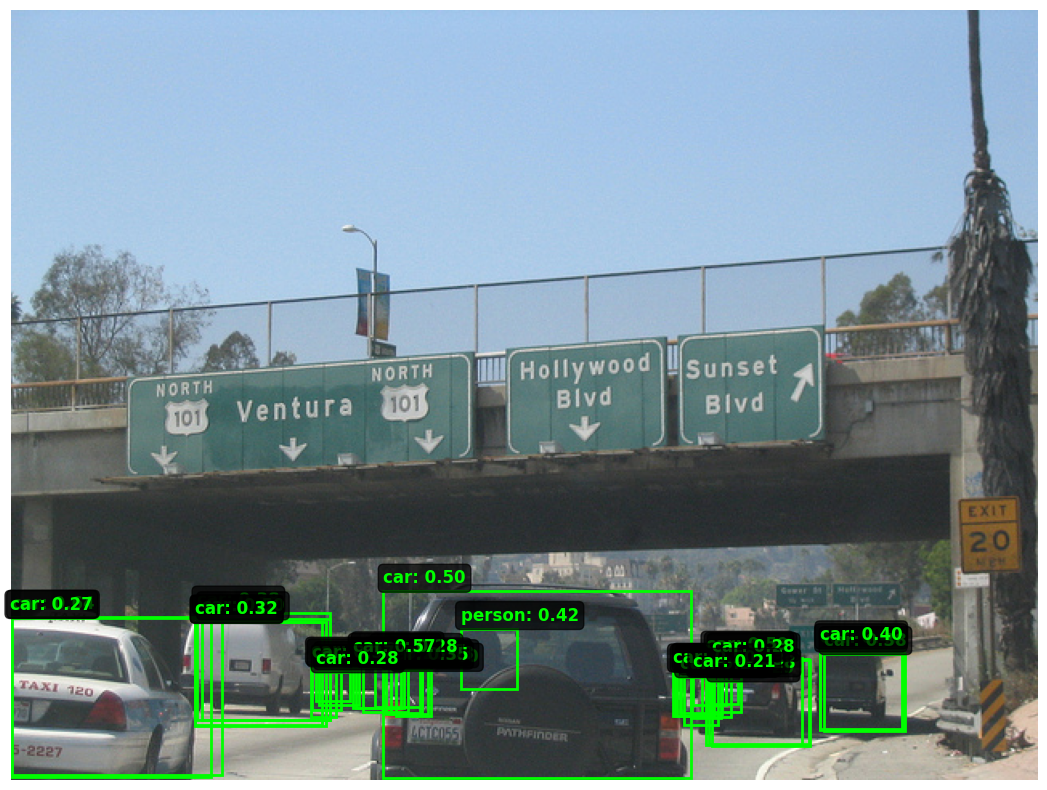

In [29]:
inference_on_image("/home/chikibriki/hw2/coco_subset_data/validation/data/000000001532.jpg", model, processor, device, DESIRED_CLASSES, threshold=0.2)

---
## 9. Results Analysis & TensorBoard

### Viewing Training Progress

Launch TensorBoard to visualize training metrics:

```bash
tensorboard --logdir=./runs
```

Then open http://localhost:6006 in your browser.

**Available Visualizations**:
- Loss curves (total, classification, bbox, GIoU)
- Learning rate schedule
- mAP metrics over time
- Prediction visualizations
- Error analysis plots
- Profiler traces

### Expected Results

After 4 epochs of training:
- **Validation Loss**: ~1.40
- **mAP@0.5**: ~0.57
- **mAP@0.75**: ~0.43


In [33]:
def load_checkpoint_for_inference(checkpoint_path, model, device):
    """
    Load a saved checkpoint for inference.
    
    Args:
        checkpoint_path: Path to checkpoint file (.pth)
        model: DETR model instance
        device: torch device
    
    Returns:
        Loaded model in eval mode
    """
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Checkpoint loaded successfully!")
    print(f"  Epoch: {checkpoint['epoch']}")
    print(f"  Validation Loss: {checkpoint['val_loss']:.4f}")
    print(f"  mAP@0.5: {checkpoint['val_map']:.4f}")
    
    return model


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Loading checkpoint from checkpoints/best_map_checkpoint.pth...
Checkpoint loaded successfully!
  Epoch: 4
  Validation Loss: 1.4732
  mAP@0.5: 0.5510


(<Figure size 1200x800 with 1 Axes>,
 {'scores': tensor([0.3847, 0.5063, 0.4077, 0.4824, 0.3040, 0.5537, 0.3942, 0.4884, 0.3613,
          0.3824, 0.3770, 0.4669, 0.5015, 0.6421, 0.3514, 0.3670, 0.4961, 0.5720,
          0.4990, 0.4891, 0.3383, 0.3334, 0.3220, 0.4029, 0.4157, 0.5866, 0.4956],
         device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          0, 1, 1], device='cuda:0'),
  'boxes': tensor([[1.1563e+02, 3.7552e+02, 1.9861e+02, 4.4188e+02],
          [1.9147e+02, 4.1010e+02, 2.1627e+02, 4.3298e+02],
          [4.2346e+02, 4.1142e+02, 4.4235e+02, 4.4090e+02],
          [5.0370e+02, 3.9898e+02, 5.5505e+02, 4.4792e+02],
          [2.3936e+02, 4.1115e+02, 2.6145e+02, 4.3942e+02],
          [4.3495e+02, 4.0421e+02, 4.9701e+02, 4.5732e+02],
          [4.2396e+02, 4.1481e+02, 4.4285e+02, 4.3824e+02],
          [4.1495e+02, 4.1109e+02, 4.3628e+02, 4.3986e+02],
          [2.1491e+02, 4.0400e+02, 2.4482e+02, 4.3447e+02],


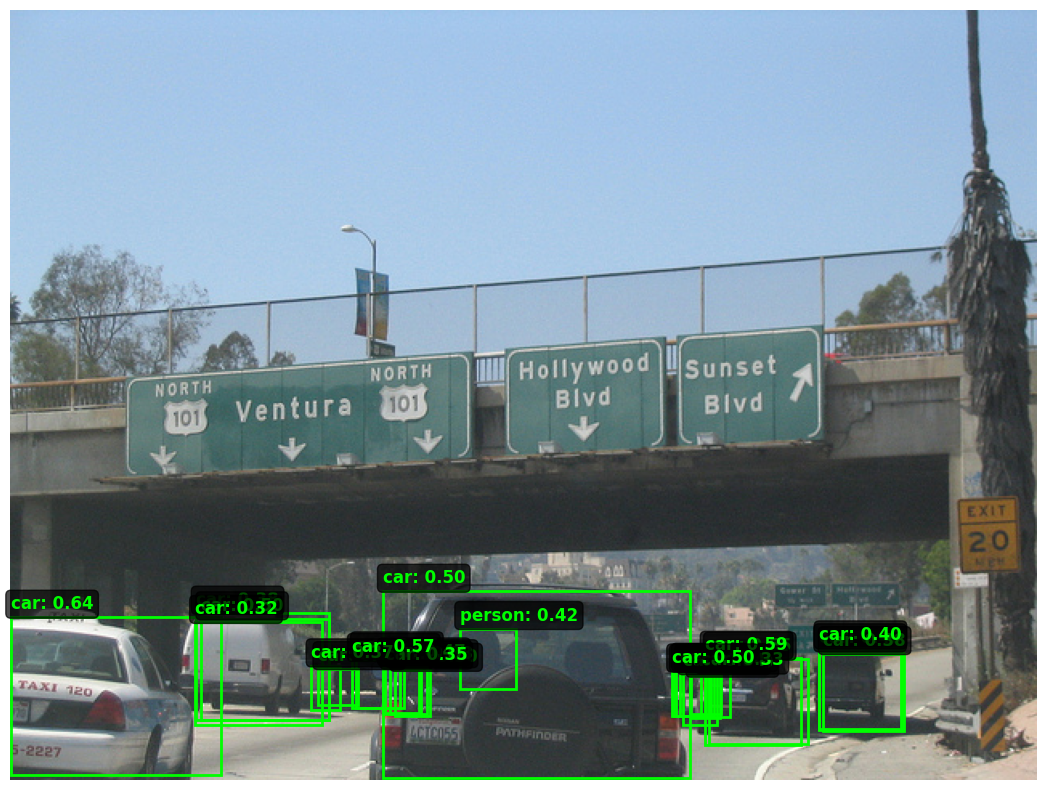

In [ ]:
# Example: Load best mAP checkpoint
model_inference = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(DESIRED_CLASSES),
    ignore_mismatched_sizes=True
).to(device)
model_inference = load_checkpoint_for_inference(
    CHECKPOINT_DIR / 'best_map_checkpoint.pth',
    model_inference,
    device
)
inference_on_image("/home/chikibriki/hw2/coco_subset_data/validation/data/000000001532.jpg", model_inference, processor, device, DESIRED_CLASSES, threshold=0.3)

(<Figure size 1200x800 with 1 Axes>,
 {'scores': tensor([0.8237], device='cuda:0'),
  'labels': tensor([0], device='cuda:0'),
  'boxes': tensor([[306.2128,  22.9353, 637.3809, 467.0051]], device='cuda:0')})

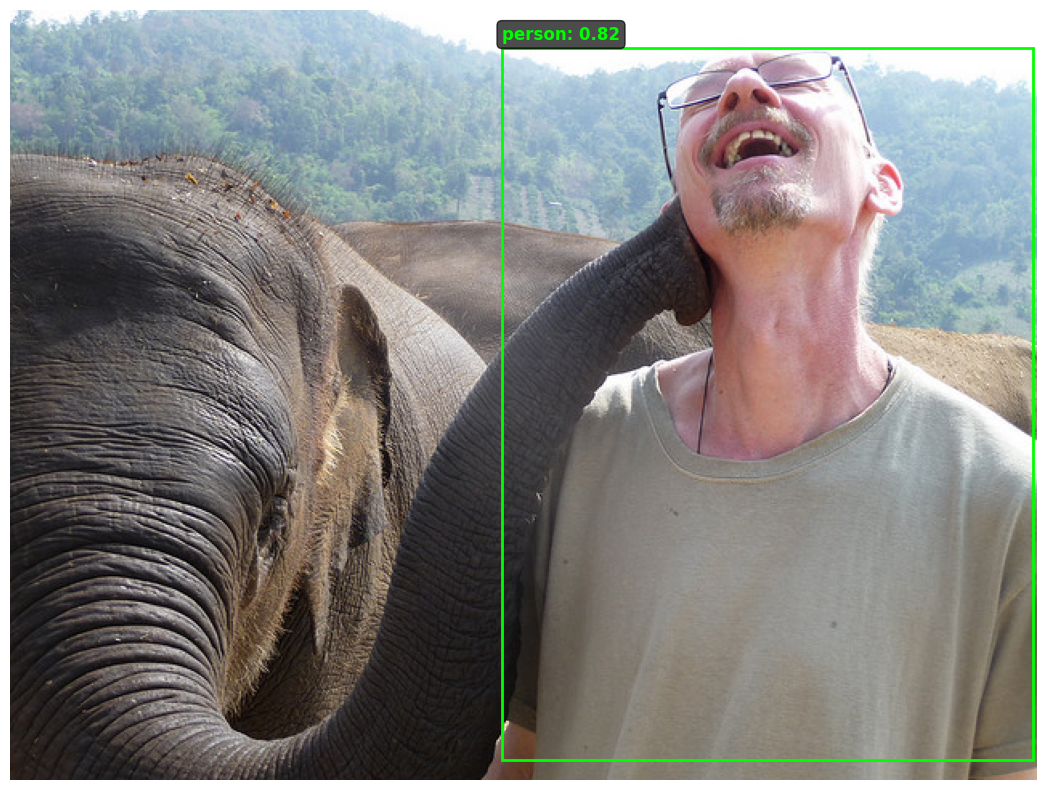

In [35]:
inference_on_image("/home/chikibriki/hw2/coco_subset_data/validation/data/000000006894.jpg", model_inference, processor, device, DESIRED_CLASSES, threshold=0.3)

---

### Deploying the Model

```python
# Save final model for deployment
model.save_pretrained('./detr_finetuned_model')
processor.save_pretrained('./detr_finetuned_processor')

# Load for inference
from transformers import DetrImageProcessor, DetrForObjectDetection

processor = DetrImageProcessor.from_pretrained('./detr_finetuned_processor')
model = DetrForObjectDetection.from_pretrained('./detr_finetuned_model')
```